# Face Recognition

In [1]:
import numpy as np
import glob
import json
from collections import defaultdict
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

## 1. Create Dataframe from images

In [2]:
list_of_dfs=[]#list of matrixes where every row is a picture with the label as first feature
pixel_list=['Pixel'+str(m) if m!=0 else 'Label'  for m in range(0,2501)]#list of features name
for n in range(1,31):#open a loop in order to import every time a folder with a person
    pic_of_a_person =glob.glob('Person'+str(n)+'/*.png')#make a list of all person picture
    for nome_immagine in pic_of_a_person:#take every picture from the list
        picture = np.array(Image.open(nome_immagine)).flatten()
        #picture = cv2.resize(np.array(Image.open(nome_immagine)),(50,50)).flatten()#convert a picture from 50x50 to 30x30 and convert the matrix into a vector
        list_of_dfs.append(np.append('Person'+str(n),picture))#append the label to the vector, and append it to the list of all pictures
    print('\r' + str(n), end='')
df = pd.DataFrame(list(map(np.ravel,list_of_dfs)))#convert the list into a DataFrame
df.columns= pixel_list#change columns' names

cols=pixel_list[1:]#take a list of all the pixels
for col in cols:
    df[col]=df[col].astype(float)#per any iteration change the datatype from string to float
    
    
# code to export the file into a .csv
df.to_csv('faces.csv',index = None, header=True, encoding='utf-8')    


30

### 1.1 Import  .csv

In [3]:
df_faces = pd.read_csv('faces.csv')

## 2. Plot the correlation matrix 

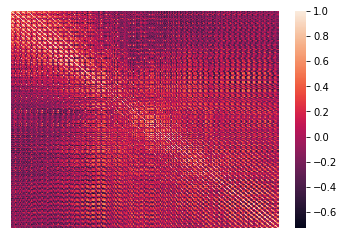

In [4]:
cor = df_faces.corr()# we compute the correlation
ax = sns.heatmap(cor, xticklabels=False, yticklabels=False)# we plot the heatmap matrix.
plt.savefig('CorrelationMatrixHeatMap1.png')# we save the picture

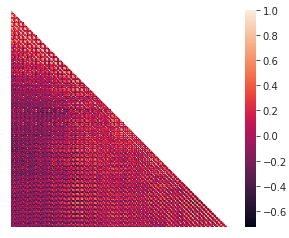

In [5]:
mask = np.zeros_like(cor)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(cor, mask=mask, xticklabels=False, yticklabels=False, vmax=1, square=True)
# we compute the heatmap but without the the results above the diagnonal, because it's specular.
plt.savefig('CorrelationMatrixHeatMapHalf.png')# we save the picture

## 3. PCA

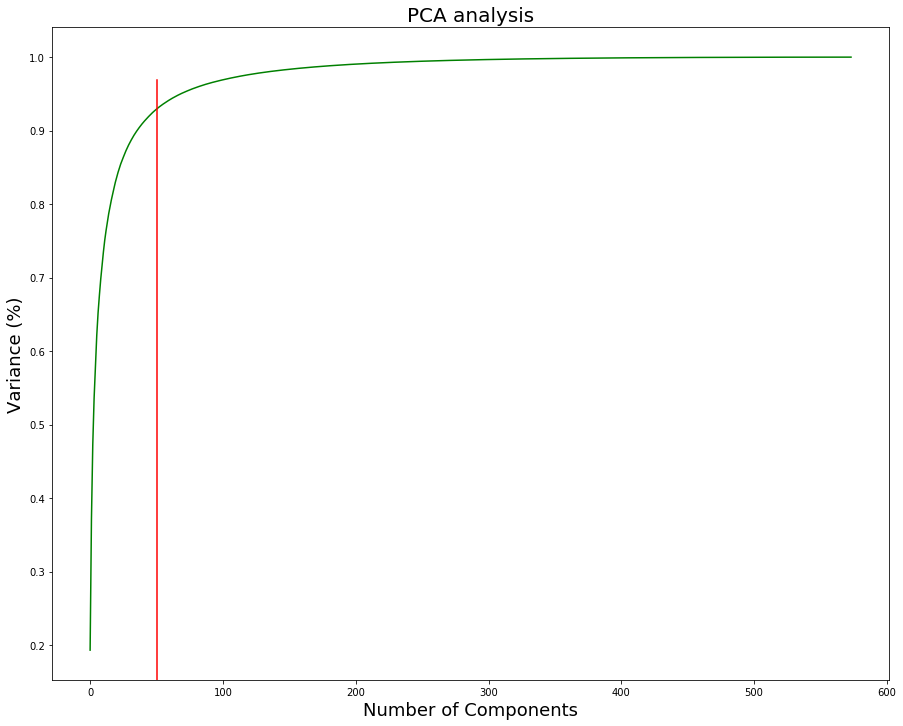

In [6]:
#Fit the PCA algorithm with our Data
pca = PCA().fit(df_faces.iloc[:,3:])

fig, ax = plt.subplots(figsize = (15,12))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='green')
plt.title('PCA analysis', fontsize = 20)
plt.xlabel('Number of Components', fontsize = 18)
plt.ylabel('Variance (%)', fontsize = 18)

ax.axvline(x=50, ymin=0, ymax=0.92,color='red')
#ax.hlines(y=0.90, xmin=30, xmax=70, color='red')

plt.savefig('PCA_selection.png')
plt.show()

### 3.1 PCA decomposition

In [7]:
df_faces.head()

,Label,Pixel1,Pixel2,Pixel3,Pixel4,Pixel5,Pixel6,Pixel7,Pixel8,Pixel9,...,Pixel2491,Pixel2492,Pixel2493,Pixel2494,Pixel2495,Pixel2496,Pixel2497,Pixel2498,Pixel2499,Pixel2500
0,Person1,244.0,239.0,221.0,104.0,34.0,24.0,13.0,7.0,34.0,...,230.0,229.0,233.0,235.0,237.0,234.0,238.0,237.0,242.0,243.0
1,Person1,244.0,236.0,227.0,133.0,40.0,27.0,17.0,8.0,27.0,...,228.0,228.0,232.0,234.0,234.0,232.0,236.0,237.0,239.0,240.0
2,Person1,240.0,235.0,176.0,51.0,27.0,18.0,8.0,11.0,77.0,...,231.0,231.0,235.0,235.0,236.0,234.0,239.0,239.0,241.0,242.0
3,Person1,242.0,236.0,208.0,82.0,34.0,26.0,16.0,12.0,51.0,...,227.0,230.0,233.0,232.0,233.0,232.0,235.0,236.0,240.0,239.0
4,Person1,228.0,206.0,78.0,29.0,27.0,19.0,15.0,11.0,48.0,...,224.0,223.0,226.0,228.0,231.0,234.0,234.0,235.0,237.0,242.0


In [8]:
pca = PCA(n_components=50)#we decide the number of components
pca.fit(df_faces.iloc[:,1:])
#we apply pca to the data (excluding the 'Label' column)
pca_data = pca.transform(df_faces.iloc[:,1:])
data_target=df_faces.iloc[:,0:1]#series of all the labels

In [9]:
pca_list=[]#it will'be a list of vectors, where every vector is the picture with 500 features
for a in pca_data:
    pca_list.append(a)
PCA_df = pd.DataFrame(list(map(np.ravel,pca_list)))#convert the list of pictures into a DataFrame
pca_df = data_target.join(PCA_df, how='outer')#we join with the serie of all the labels.

In [10]:
pca_df.shape

(574, 51)

## 4. Split Training and Test set

In [11]:
X = pca_df.drop(['Label'], axis='columns')# we drop the label column from our df
y = pca_df.Label # we create a serie where we store all the labels

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)#20%test 

## 5. Tuning Paramiters

In [12]:
# A classifier is defined. Where there are the four selected models
classifiers = {
    'knn':KNeighborsClassifier(),
    'dtc': DecisionTreeClassifier(),
    'svm': SVC(),
    'rf': RandomForestClassifier(),
    'ada': AdaBoostClassifier()
              }

# a paramiter dict where there are all the paramiters that have to be tuned.
paramiters = {
    'knn':{'n_neighbors':[int(x) for x in np.linspace(1, 200, num = 5)], 'weights':['uniform','distance']},
    
    'dtc':{'max_depth':[5,10], 'max_features':[int(x) for x in np.linspace(1, 23, num = 5)]},
    
    'svm': [{'kernel': ['rbf'], 'gamma': [1e-1,1e-2,1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}],
    
    'rf': {
        'n_estimators': [int(x) for x in np.linspace(10,500, num = 3)],
        'max_depth': [int(x) for x in np.linspace(10, 100, 3)],
        'bootstrap': [True,False]
        
    },
        'ada':{
        'n_estimators': [500,1000,2000],
        'learning_rate':[0.01,.1,1]
    }
          }

In [13]:
gs_scores = {} # dictionary where will be stored all the scores
gs_paramiters = {} # dictionary where will be stored all the tested paramiters 
gs_estimators = {} # dictionary where will be stored all the estimators
for k in classifiers.keys():# we run up to all the models are tuned
    grid = GridSearchCV(
        classifiers[k], 
        paramiters[k], 
        cv = KFold(n_splits=10, random_state=25, shuffle=True), 
        scoring = 'accuracy')
    
    grid.fit(X_train,y_train)
    gs_scores[k] = grid.grid_scores_
    gs_paramiters[k] = grid.best_params_
    gs_estimators[k] = grid.best_estimator_

C:\Users\Francesco\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\Francesco\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\Francesco\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\Francesco\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWa

In [14]:
gs_estimators

{'knn': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=1, p=2,
            weights='uniform'),
 'dtc': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
             max_features=17, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 'svm': SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 'rf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=100, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
         

## 6. Coss Validation with best selected paramiters

In [15]:
accuracy_results = defaultdict() # dictionary where we are going to store the accuracy for each model
confusion_matrices = defaultdict() # we store the confusion matrix that later we'll plot
cross_validation = defaultdict()


    
for k in gs_estimators.keys(): # now we call, one by one, all the models

    model_selected = gs_estimators[k] # we select the model for the tuned models
    cross_validation_score = cross_val_score(model_selected, X_train, y_train, cv=10)
    model_selected.fit(X_train,y_train) # we fit the model with the train set
    y_prediction = model_selected.predict(X_test) # we make the prediction
    
    
    
    cross_validation[k] = cross_validation_score.tolist() # store cross validation scores
    accuracy_results[k] = accuracy_score(y_test,y_prediction) # store accuracy
    confusion_matrices[k] = confusion_matrix(y_test, y_prediction) # store confusion matrices

C:\Users\Francesco\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Francesco\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Francesco\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Francesco\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 3 members, which

### 6.1 Box-Plot model comparision

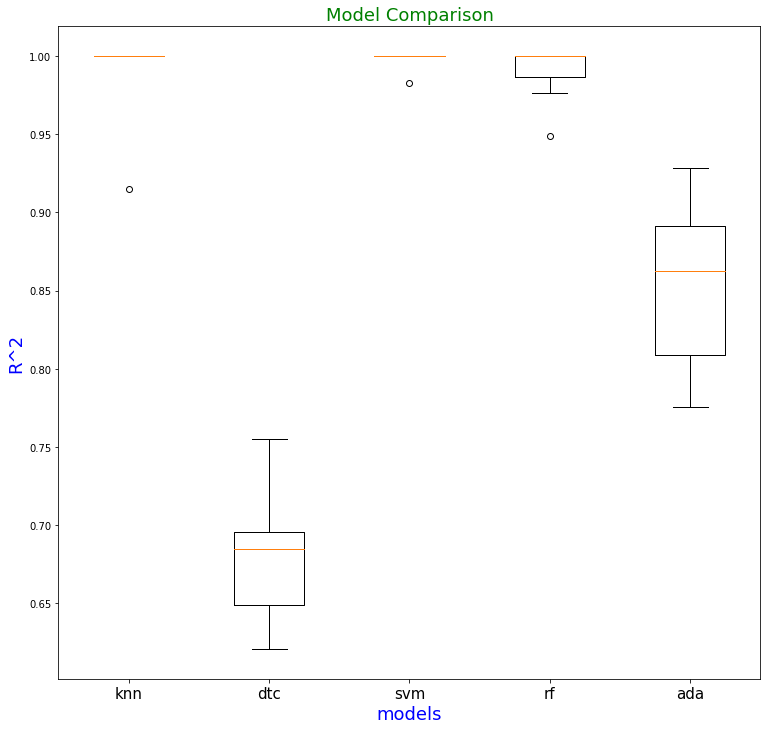

In [16]:
labels, data = [*zip(*cross_validation.items())] 
labels, data = cross_validation.keys(), cross_validation.values()

plt.figure(figsize = (15,12))
plt.subplots_adjust(left=0.25)
plt.boxplot(data)

plt.title('Model Comparison', fontsize=18, color = 'green')
plt.xticks(range(1, len(labels) + 1), labels, fontsize = 15)
plt.xlabel('models', fontsize=18).set_color("Blue")
plt.ylabel('R^2', fontsize=18).set_color("Blue")

plt.savefig('modelsR2_strange2.png')
plt.show()

### 6.2 Correlation Matrix

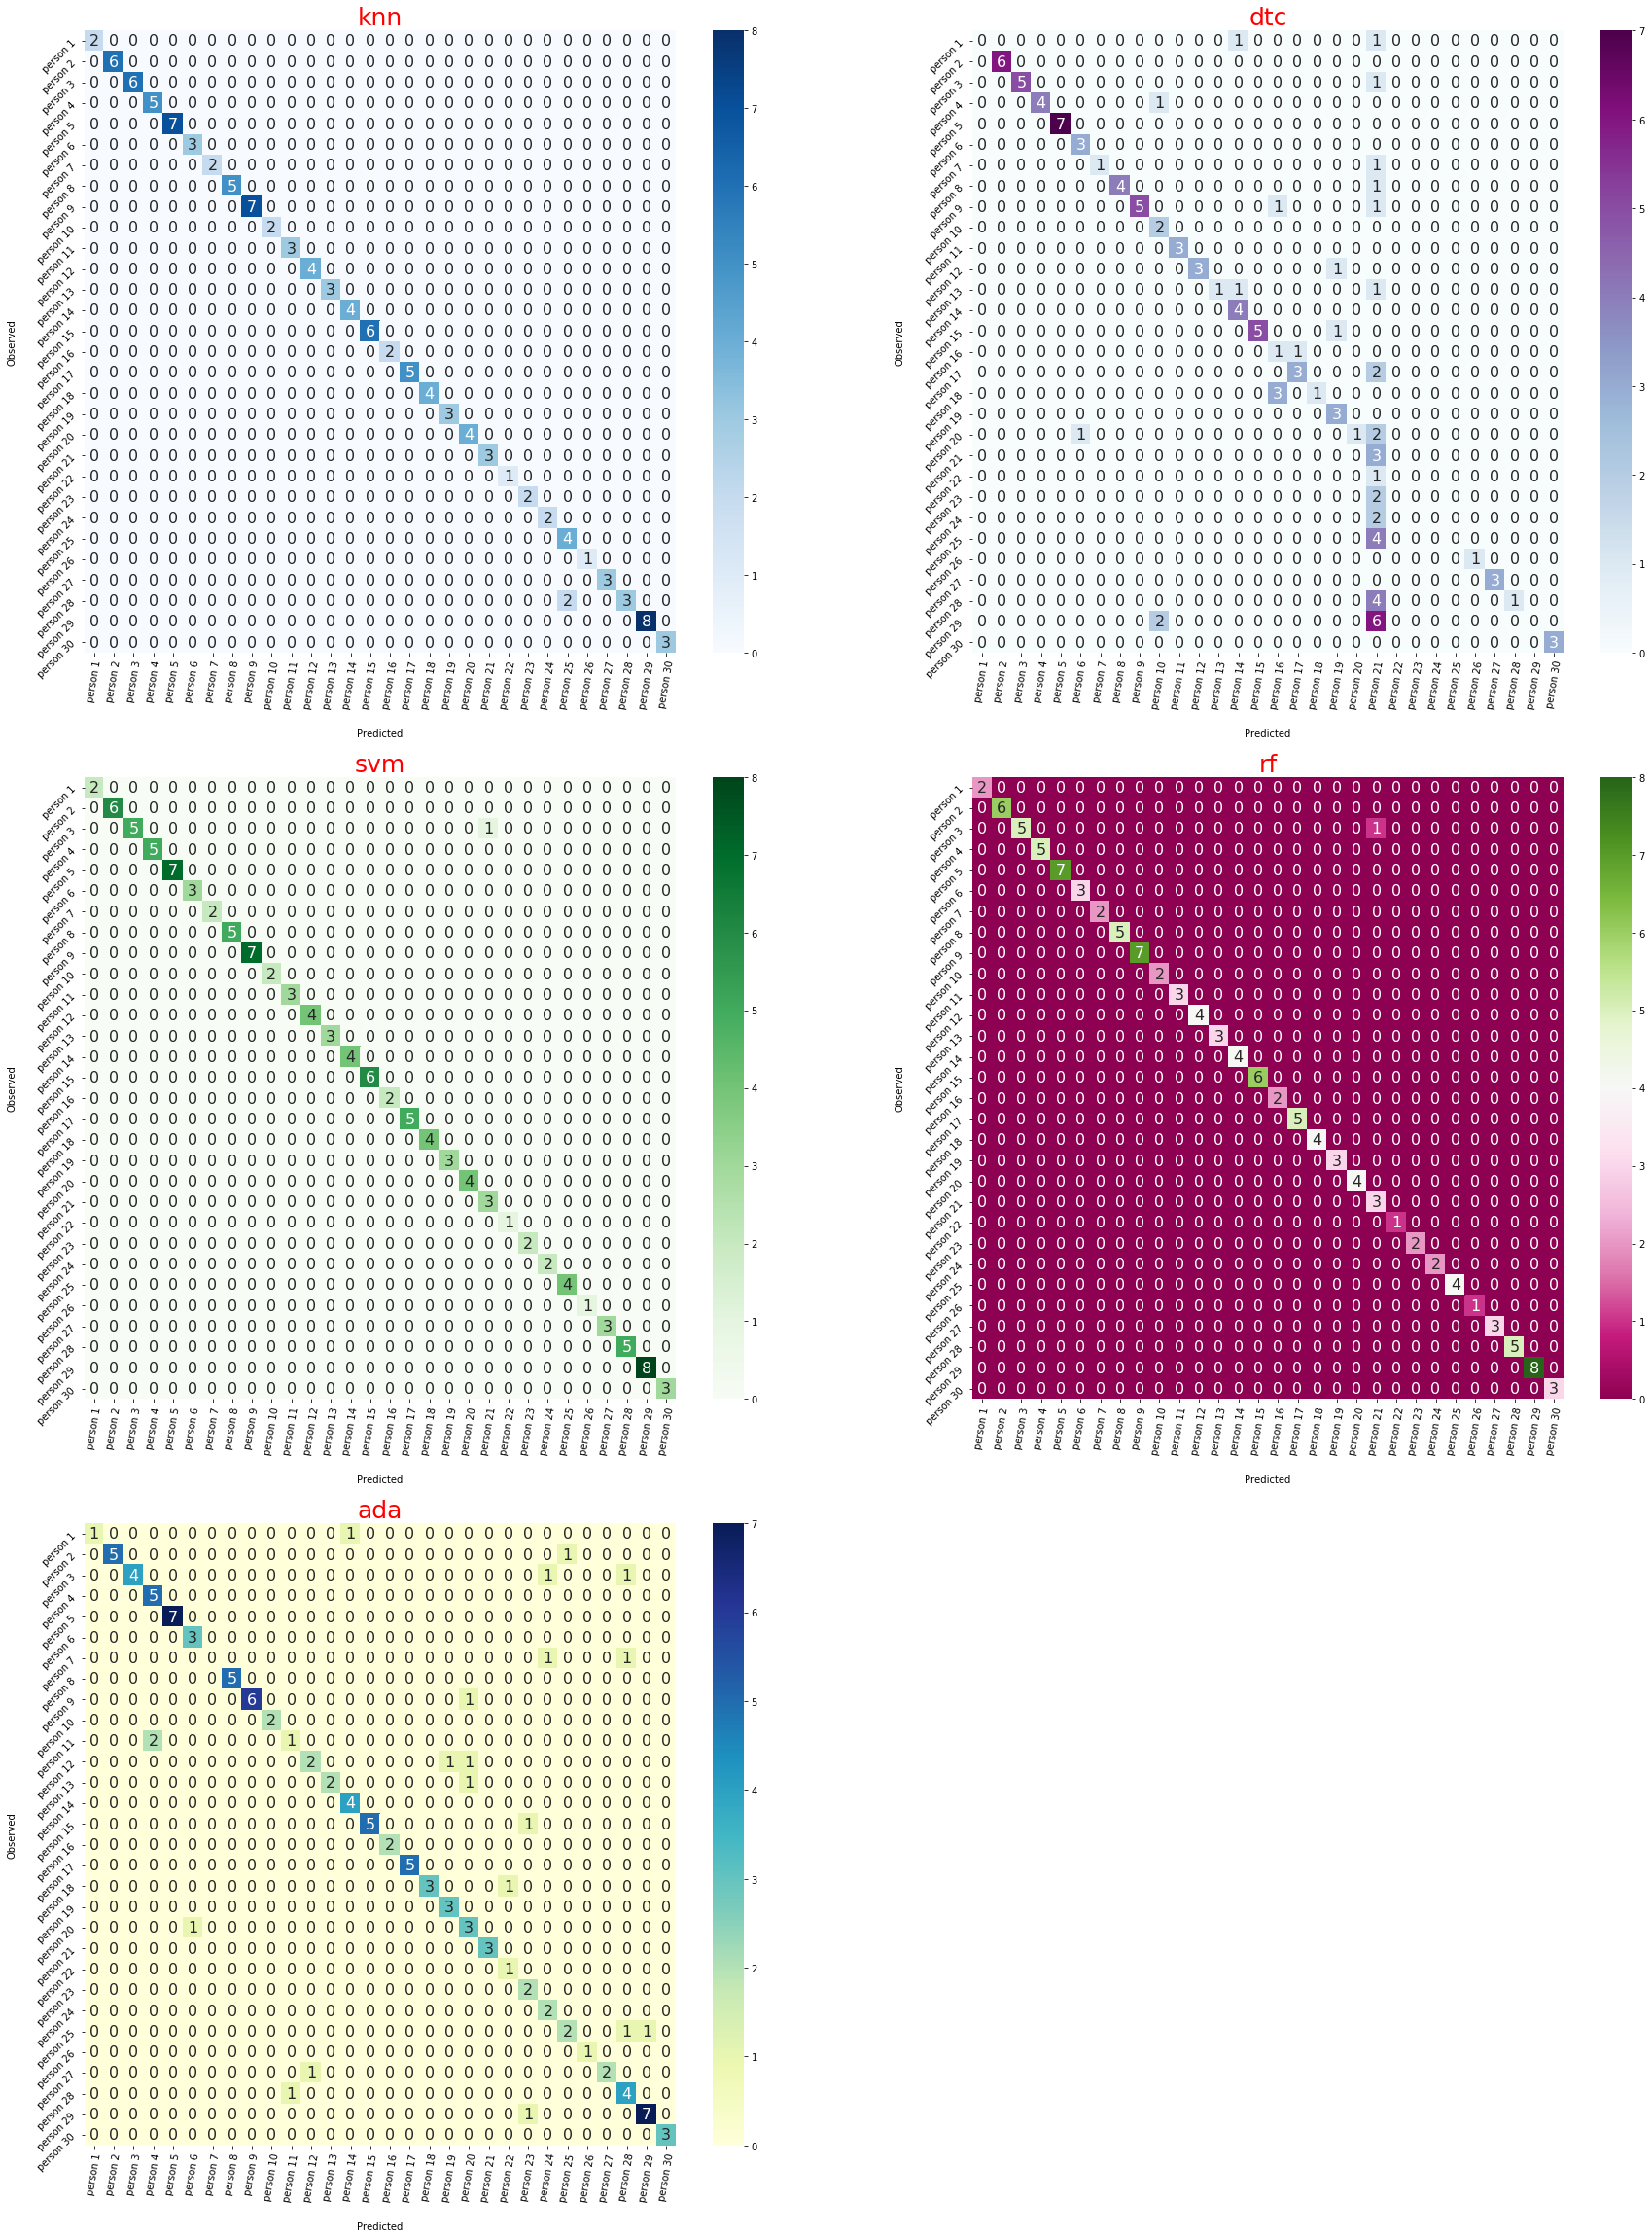

In [17]:
colors_map = ['Blues', 'BuPu', 'Greens', 'PiYG', 'YlGnBu']
people = ['person '+str(n) for n in range(1,31)]


fig = plt.figure(figsize=(30,40))

for e, k in enumerate(confusion_matrices.keys()):
    ax = fig.add_subplot(3, 2, (e+1))
    sns.heatmap(confusion_matrices[k], cmap= colors_map[e], annot=True, annot_kws={'size':16}, ax = ax)
    ax.set_title(k, color='Red', fontsize=25)
    
    ax.set_xticklabels(people,fontsize=10, rotation=80)
    ax.set_yticklabels(people,fontsize=10,  rotation=45)

    ax.set(xlabel='Predicted', ylabel='Observed')
    
    ax.yaxis.labelpad = 20
    ax.xaxis.labelpad = 20

### 6.3 Histogram accuracy score

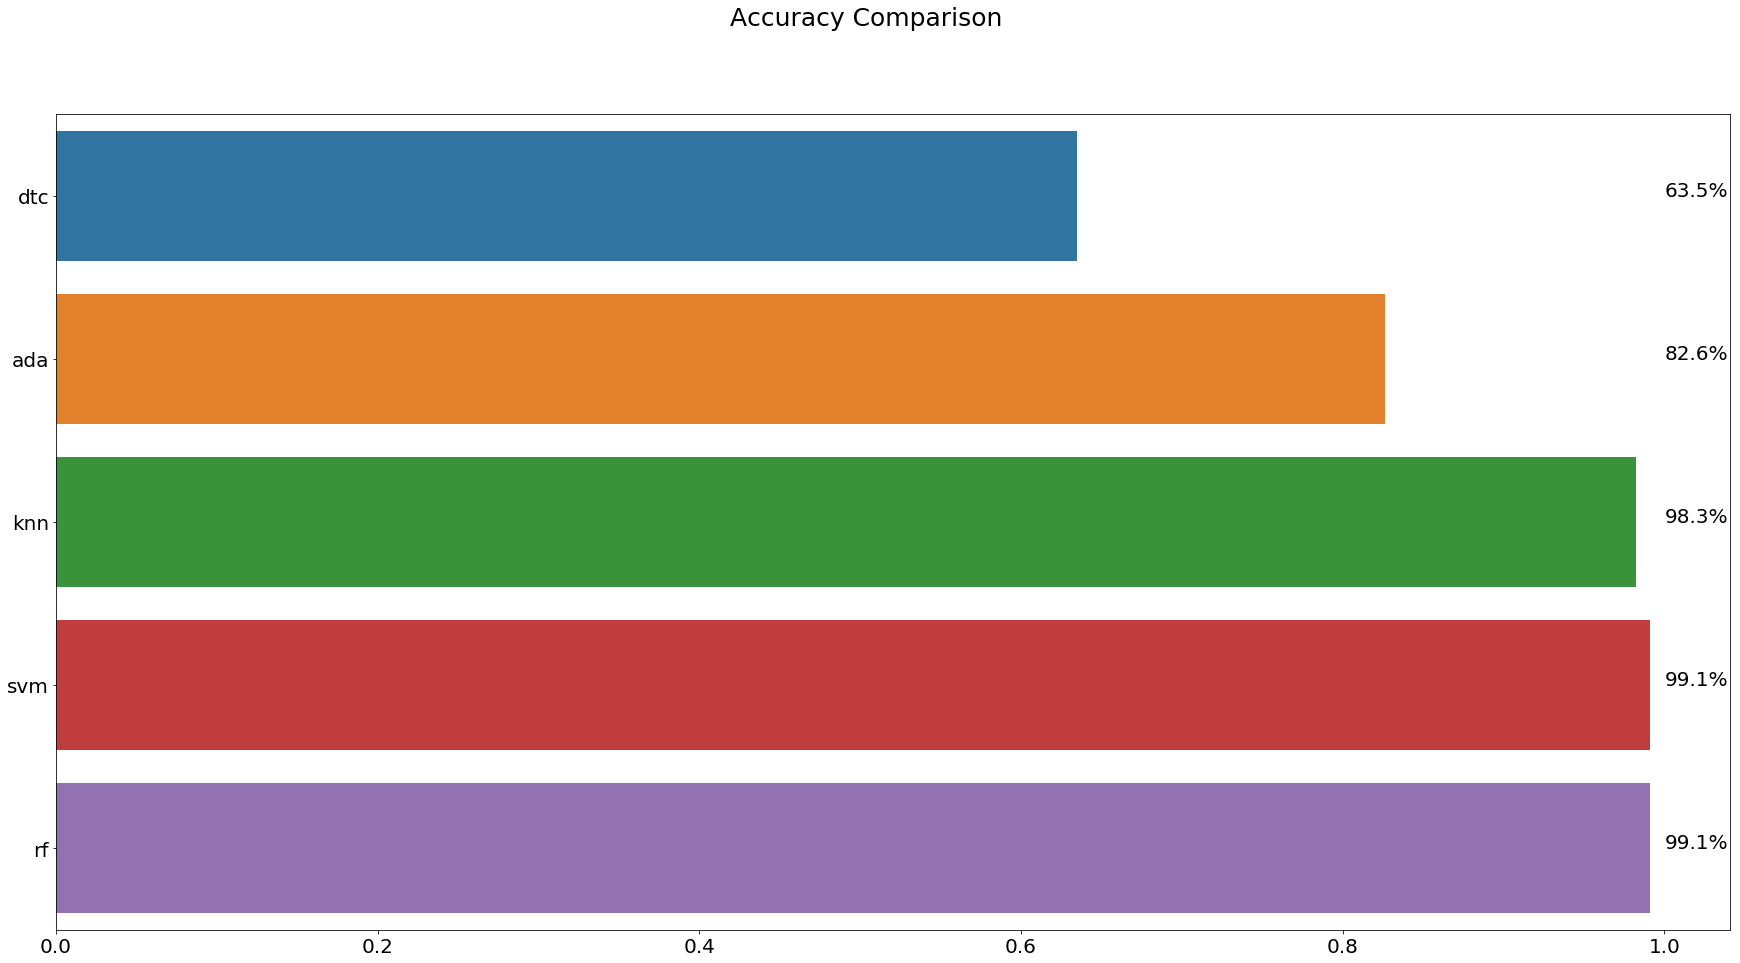

In [18]:
fig = plt.figure(figsize=(30,15))
fig.suptitle('Accuracy Comparison', fontsize=25)
accuracy_df = pd.DataFrame.from_dict({k:[v] for k,v in accuracy_results.items()}, orient='index').reset_index().rename(columns={'index':'models', 0:'accuracies'}).sort_values(by=['accuracies']).reset_index(drop=True)
ax = sns.barplot(x = 'accuracies' , y = 'models', data= accuracy_df, orient = "h")
ax.tick_params(axis='both', labelsize=20)
ax.set_xlabel('') 
ax.set_ylabel('')
for e,p in enumerate(ax.patches):
    percentage = str(round(accuracy_df['accuracies'][e],3)*100)+'%'
    x = p.get_x() + 1 
    y = p.get_y() + 0.4
    ax.annotate(percentage, (x, y),fontsize=20)

## 7. If we delete one person from the df and we try to detect him.

In [19]:
df2 = pca_df.tail(20)#we delate the person30
X2_test = df2.iloc[:,1:]#training dataset with data of only 29 people
y2_test = df2.Label#training labels
X2_train = pca_df.iloc[:554,1:]#test dataset with unknow person
y2_train = pca_df.iloc[:554,0]##test labels

In [20]:
for  k in gs_estimators.keys():
    model_selected2 = gs_estimators[k]
    model_selected2.fit(X2_train, y2_train)
    y_prediction2 = model_selected2.predict(X2_test)
    print(accuracy_score(y2_test,y_prediction2))

0.0
0.0
0.0
0.0
0.0
